## Background
So now that we have generated our feature archetypes, we want to write a function to classify unknown cross-sections and find out which archetypes are the most useful.

In [73]:
import importlib
import random

import archetypes
from archetypes import load_from_file

importlib.reload(archetypes)

archetypes = load_from_file("archetypes.json")
archetypes = [a for a in archetypes.values() if a.feature_type in ["Crater, craters", "Mons, montes", "Vallis, valles"]]

In [76]:
from archetypes import Archetype
import util
importlib.reload(util)

from util import generate_normalized_cross_sections, plot_cross_section
import json
import random

feature_types_with_archetype = [a.feature_type for a in archetypes]

with open("testing_features.json", "r") as f:
    data = f.read()

testing_features = json.loads(data)

# Filter out any testing features that we don't have an archetype for
testing_features = [feature for feature in testing_features if feature["featuretype"] in feature_types_with_archetype]

def calc_avg_error(cross_section: util.CrossSection, archetype: Archetype):
    total_error = 0.0

    for x, y in archetype.line:
        total_error += abs(y - util.get_y_value(cross_section, x))

    return total_error / len(archetype.line)

random.shuffle(testing_features)

def make_prediction(feature: dict) -> str:
    # print(feature["name"], f"({feature['featuretype']})")

    # Generate cross-sections
    cross_sections = generate_normalized_cross_sections(feature)

    # for cs in cross_sections:
    #     plot_cross_section(cs)

    results: list[tuple[Archetype, float]] = []

    for archetype in archetypes:
        total_error = 0.0

        for cs in cross_sections:
            total_error += calc_avg_error(cs, archetype)

        avg_error = total_error / len(cross_sections)

        results.append((archetype, avg_error))

        # print(f"Avg error for {archetype.feature_type}: {avg_error}")

    results.sort(key=lambda x: x[1])

    # print(f"Most likely feature type: {results[0][0].feature_type}\n")

    return results[0][0].feature_type

In [78]:
print("Num testing features by feature type:")
for archetype in archetypes:
    print(f"{archetype.feature_type}:", len([i for i in testing_features if i["featuretype"] == archetype.feature_type]))

all_feature_types = set([i["featuretype"] for i in testing_features])

Num testing features by feature type:
Mons, montes: 15
Crater, craters: 196
Vallis, valles: 37


In [79]:
predictions: list[tuple[str, str]] = []

for feature in testing_features:
    prediction = make_prediction(feature)

    predictions.append((feature["featuretype"], prediction))


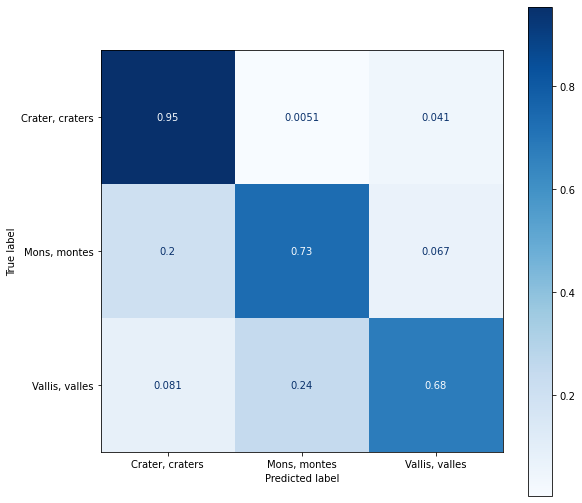

In [86]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

y_true, y_pred = zip(*predictions)

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cf = confusion_matrix(y_true, y_pred, normalize='true')

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true', cmap="Blues")

#
# ax = sns.heatmap(cf, annot=True, cmap='Blues')
#
# ax.set_title('Confusion Matrix\n\n')
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['False','True'])
# ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.gcf().set_size_inches(9, 9)
plt.show()